<a href="https://colab.research.google.com/github/scrambleegg7/ATARI/blob/master/rsna_resize_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The DICOM format is so cool, but I prefer normal images :)

With 156GB (compressed) it is very difficult to work with the resources of the vast majority of the mortals.
This notebook shows you how to scale down all the images and create a new dataset easier to deal with.
Even with the best computing resources, I don't think it's necessary to use the original size to get good accuracy.

If you feel that you need bigger images or you want to store the images in another format you only need to change a couple of lines in the next section (Constants).

Some code taken from:
* https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
* https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109649#latest-631701

# Configuration

In [0]:
# Desired output size.
RESIZED_WIDTH, RESIZED_HEIGHT = 128, 128

OUTPUT_FORMAT = "png"

OUTPUT_DIR = "output"

# Installations

In [0]:
%%capture

# Uninstall and reinstall kaggle because I'm getting and error: the kaggle script
# is running on Python 2 instead of Python 3 and fails when downloading kernel
# outputs.
# It's also needed for download data for this competition.
!pip uninstall -y kaggle
!pip install kaggle

In [0]:
%%capture

# Install this library for reading the *.dcm images of this competition.
!pip install pydicom

In [0]:
%%capture

# Mount fuse-zip to mount zip files so we can access the files without unzip it.
# This is needed because of the lack of space in Google Colab disk.
!apt-get install -y fuse-zip

# Imports

In [0]:
import glob
import os

import joblib

import numpy as np

import PIL

import pydicom

import tqdm

# Setup

In [0]:
# Set environment variables for using the Kaggle API.
os.environ["KAGGLE_USERNAME"] = "YOUR USERNAME HERE"
os.environ["KAGGLE_KEY"] = "YOUR KEY HERE"

# Get the data

In [0]:
# 30-45min in Google Colab.
raw_data_dir = "input/raw"
!kaggle competitions download -c rsna-intracranial-hemorrhage-detection -p {raw_data_dir}

100% 156G/156G [47:03<00:00, 76.9MB/s]
100% 156G/156G [47:03<00:00, 59.3MB/s]


# Mount ZIP with fuse-zip

In [0]:
%%time
# Around 10 min in Google Colab.

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/rsna-intracranial-hemorrhage-detection.zip {input_dir}

In [0]:
# Check that everything is working.
!ls {input_dir}

stage_1_sample_submission.csv  stage_1_train.csv
stage_1_test_images	       stage_1_train_images


# Get images path

In [0]:
train_dir = "stage_1_train_images"
train_paths = glob.glob(f"{input_dir}/{train_dir}/*.dcm")
test_dir = "stage_1_test_images"
test_paths = glob.glob(f"{input_dir}/{test_dir}/*.dcm")
len(train_paths), len(test_paths)

(674258, 78545)

# Preprocess all data

First declare a bunch of useful functions.

In [0]:
def get_first_of_dicom_field_as_int(x):
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    return int(x)

def get_id(img_dicom):
    return str(img_dicom.SOPInstanceUID)

def get_metadata_from_dicom(img_dicom):
    metadata = {
        "window_center": img_dicom.WindowCenter,
        "window_width": img_dicom.WindowWidth,
        "intercept": img_dicom.RescaleIntercept,
        "slope": img_dicom.RescaleSlope,
    }
    return {k: get_first_of_dicom_field_as_int(v) for k, v in metadata.items()}

def window_image(img, window_center, window_width, intercept, slope):
    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    return img 

def resize(img, new_w, new_h):
    img = PIL.Image.fromarray(img.astype(np.int8), mode="L")
    return img.resize((new_w, new_h), resample=PIL.Image.BICUBIC)

def save_img(img_pil, subfolder, name):
    img_pil.save(f"{OUTPUT_DIR}/{subfolder}/{name}.{OUTPUT_FORMAT}")

def normalize_minmax(img):
    mi, ma = img.min(), img.max()
    return (img - mi) / (ma - mi)

def prepare_image(img_path):
    img_dicom = pydicom.read_file(img_path)
    img_id = get_id(img_dicom)
    metadata = get_metadata_from_dicom(img_dicom)
    img = window_image(img_dicom.pixel_array, **metadata)
    img = normalize_minmax(img) * 255
    img_pil = resize(img, RESIZED_WIDTH, RESIZED_HEIGHT)
    return img_id, img_pil

def prepare_and_save(img_path, subfolder):
    try:
        img_id, img_pil = prepare_image(img_path)
        save_img(img_pil, subfolder, img_id)
    except KeyboardInterrupt:
        # Rais interrupt exception so we can stop the cell execution
        # without shutting down the kernel.
        raise
    except:
        print(f"Error processing the image: {img_path}")

def prepare_images(imgs_path, subfolder):
    for i in tqdm.tqdm(imgs_path):
        prepare_and_save(i, subfolder)

def prepare_images_njobs(img_paths, subfolder, n_jobs=-1):
    joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(prepare_and_save)(i, subfolder) for i in tqdm.tqdm(img_paths))

In [0]:
!mkdir -p {OUTPUT_DIR}/{train_dir}
!mkdir -p {OUTPUT_DIR}/{test_dir}

In [0]:
prepare_images_njobs(train_paths, train_dir)
prepare_images_njobs(test_paths, test_dir)

100%|██████████| 78545/78545 [13:14<00:00, 98.83it/s] 


In [0]:
# Copy also extra files.
!cp {input_dir}/stage_1_sample_submission.csv {OUTPUT_DIR}/
!cp {input_dir}/stage_1_train.csv {OUTPUT_DIR}/

# Load converted images

Let's test that everything is ok!

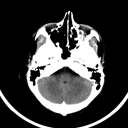

In [0]:
train_output_path = glob.glob(f"{OUTPUT_DIR}/{train_dir}/*")
img_path = train_output_path[0]
PIL.Image.open(img_path)

# Create Kaggle dataset

In [0]:
cmd = """
cat <<EOF > output/dataset-metadata.json
{
  "title": "RSNA Train/Test png (128x128)",
  "id": "guiferviz/rsna_png_128_128",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}
EOF
"""
!eval {cmd}

In [0]:
!cat output/dataset-metadata.json

{
  "title": "RSNA Train/Test png (128x128)",
  "id": "guiferviz/rsna_png_128_128",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [0]:
!kaggle datasets create -u --dir-mode zip -p {OUTPUT_DIR}

Starting upload for file stage_1_train.csv
100% 102M/102M [00:13<00:00, 7.95MB/s] 
Upload successful: stage_1_train.csv (102MB)
Starting upload for file stage_1_test_images.zip
100% 353M/353M [00:17<00:00, 21.1MB/s]
Upload successful: stage_1_test_images.zip (353MB)
Starting upload for file stage_1_sample_submission.csv
100% 12.8M/12.8M [00:08<00:00, 1.54MB/s]
Upload successful: stage_1_sample_submission.csv (13MB)
Starting upload for file stage_1_train_images.zip
100% 2.87G/2.87G [01:16<00:00, 40.5MB/s]
Upload successful: stage_1_train_images.zip (3GB)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/guiferviz/rsna_png_128_128
